<a href="https://colab.research.google.com/github/sarmientoj24/EE298/blob/master/PUBG_Final_ANNv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
from google.colab import drive
drive.mount('/content/drive')
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
random.seed(42)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
!chmod 600 '/content/drive/My Drive/pubg/train/train_V2.csv'
!chmod 600 '/content/drive/My Drive/pubg/test/test_V2.csv'
INPUT_DIR = '/content/drive/My Drive/pubg'

# Specific imports
from sklearn.metrics import mean_absolute_error

Mounted at /content/drive


In [0]:
# Helper Functions
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    return df

def reload():
  print("Building dataframe...")
  gc.collect()
  # df = reduce_mem_usage(pd.read_csv(INPUT_DIR + '/train/train_V2.csv')) # <=========== Just a function to reduce memory usage
  df = pd.read_csv(INPUT_DIR + '/train/train_V2.csv')
  # Only take the samples with matches that have more than 1 player 
  # there are matches with no players or just one player ( those samples could affect our model badly) 
  df = df[df['maxPlace'] > 1]
  invalid_match_ids = df[df['winPlacePerc'].isna()]['matchId'].values
  df = df[-df['matchId'].isin(invalid_match_ids)]
  print("Done loading train to dataframe...")
  return df

def train_test_split(df, test_size=0.1):
  match_ids = df['matchId'].unique().tolist()
  train_size = int(len(match_ids) * (1 - test_size))
  train_match_ids = random.sample(match_ids, train_size)

  train = df[df['matchId'].isin(train_match_ids)]
  test = df[-df['matchId'].isin(train_match_ids)]

  return train, test
  
# Split train to train and eval set
def generate_train_test_set(df, split):
  print("Generating train and test set...")
  # df.drop(columns=['matchType'], inplace=True)
  
  cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType']
  cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
  train, val = train_test_split(df, split)
  
  return train[cols_to_fit], val[cols_to_fit]

def generate_train_set(df):
  print("Generating train and test set...")
  # df.drop(columns=['matchType'], inplace=True)
  
  cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType']
  cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
  train = df
  
  return train[cols_to_fit]

def load_test():
  print("Building dataframe...")
  df = reduce_mem_usage(pd.read_csv(INPUT_DIR + '/test/test_V2.csv')) # <=========== Just a function to reduce memory usage

  cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType']
  cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
  print("Done loading train to dataframe...")
  return df[cols_to_fit]

def transform_preds(df_test, pred):
  for i in range(len(df_test)):
      winPlacePerc_m = pred[i]
      maxPlace = int(df_test.iloc[i]['maxPlace'])
      if maxPlace == 0:
          winPlacePerc_m = 0.0
      elif maxPlace == 1:
          winPlacePerc_m = 1.0
      else:
          gap = 1.0 / (maxPlace - 1)
          winPlacePerc_m = np.round(winPlacePerc_m / gap) * gap

      if winPlacePerc_m < 0: winPlacePerc_m = 0.0
      if winPlacePerc_m > 1: winPlacePerc_m = 1.0    
      pred[i] = winPlacePerc_m

      if (i + 1) % 100000 == 0:
          print(i, flush=True, end=" ")

  df_test['winPlacePerc_mod'] = pred
  return df_test

def save_for_submission(df, path):
  submission = df[['Id', 'winPlacePerc']]
  submission.to_csv(path + 'submission.csv', index=False)

In [0]:
# Feature Engineering
# Helper Functions

def get_playersJoined(df):
  df['playersJoined'] = df.groupby('matchId')['matchId'].transform('count')
  return df

def get_killsNorm(df):
  if 'playersJoined' not in df.columns:
    df = get_playersJoined(df)
  df['killsNorm'] = df['kills']*((100-df['playersJoined'])/100 + 1)
  return df

def get_damageDealtNorm(df):
  if 'playersJoined' not in df.columns:
    df = get_playersJoined(df)
  df['damageDealtNorm'] = df['damageDealt']*((100-df['playersJoined'])/100 + 1)
  return df

def get_healsAndBoosts(df):
  df['healsAndBoosts'] = df['heals'] + df['boosts']
  return df

def get_totalDistance(df):
  df['totalDistance'] = df['walkDistance']+ df['rideDistance']+ df['swimDistance']
  return df

def get_team(df):
  df['team'] = [1 if i>50 else 2 if (i>25 & i<=50) else 4 for i in df['numGroups']]
  return df

def get_players_in_team(df):
    agg = df.groupby(['groupId']).size().to_frame('players_in_team')
    return df.merge(agg, how='left', on=['groupId'])

def get_headshotKills_over_kills(df):
  df['headshotKills_over_kills'] = df['headshotKills'] / df['kills']
  df['headshotKills_over_kills'].fillna(0, inplace=True)
  return df

def get_killPlace_over_maxPlace(df):
    df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace']
    df['killPlace_over_maxPlace'].fillna(0, inplace=True)
    df['killPlace_over_maxPlace'].replace(np.inf, 0, inplace=True)
    return df

def get_walkDistance_over_heals(df):
    df['walkDistance_over_heals'] = df['walkDistance'] / df['heals']
    df['walkDistance_over_heals'].fillna(0, inplace=True)
    df['walkDistance_over_heals'].replace(np.inf, 0, inplace=True)
    return df
  
def get_walkDistance_over_boosts(df):
    df['walkDistance_over_boosts'] = df['walkDistance'] / df['boosts']
    df['walkDistance_over_boosts'].fillna(0, inplace=True)
    df['walkDistance_over_boosts'].replace(np.inf, 0, inplace=True)
    return df

def get_walkDistance_over_kills(df):
    df['walkDistance_over_kills'] = df['walkDistance'] / df['kills']
    df['walkDistance_over_kills'].fillna(0, inplace=True)
    df['walkDistance_over_kills'].replace(np.inf, 0, inplace=True)
    return df

def get_teamwork(df):
    df['teamwork'] = df['assists'] + df['revives']
    return df

# BY AGGREGATES, meaning, they calculate mean/max/min, etc of each columns then add it into the left of the existing one
def add_min_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId','groupId'])[features].min()
    return df.merge(agg, suffixes=['', '_min'], how='left', on=['matchId', 'groupId'])

def add_max_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].max()
    return df.merge(agg, suffixes=['', '_max'], how='left', on=['matchId', 'groupId'])

def add_sum_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].sum()
    return df.merge(agg, suffixes=['', '_sum'], how='left', on=['matchId', 'groupId'])

def add_median_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].median()
    return df.merge(agg, suffixes=['', '_median'], how='left', on=['matchId', 'groupId'])

def add_mean_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].mean()
    return df.merge(agg, suffixes=['', '_mean'], how='left', on=['matchId', 'groupId'])

def add_rank_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].mean()
    agg = agg.groupby('matchId')[features].rank(pct=True)
    return df.merge(agg, suffixes=['', '_mean_rank'], how='left', on=['matchId', 'groupId'])

  

In [0]:
# Build the NEURAL NET
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization, PReLU, LeakyReLU
from keras.models import load_model
from keras import optimizers, regularizers
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# adjusted because im still testing so i reduced hidden units from 64 to 32, epoch reduced
class NNModel():
  # network parameters
  batch_size = 32
  hidden_units = 64
  dropout = 0.2
  optimizer = 'adam'
  
  def __init__(self, input_size, reload=False, path=None):
    if reload:
      self.model = load_model(path)
    else:
      # Regression has 1 output layer
      output_shape = 1

      self.model = model = Sequential()
      self.model.add(Dense(self.hidden_units, input_dim=input_size, init="glorot_uniform", bias_initializer='zeros'))
      # self.model.add(LeakyReLU(alpha=self.leaky_relu))
      self.model.add(Activation('sigmoid'))
      self.model.add(Dropout(self.dropout))
      self.model.add(Dense(self.hidden_units, init="glorot_uniform", bias_initializer='zeros'))
      self.model.add(Activation('sigmoid'))
      # self.model.add(LeakyReLU(alpha=self.leaky_relu))
      self.model.add(Dropout(self.dropout))
      self.model.add(Dense(output_shape))
      # this is the output for one-hot vector
      self.model.add(Activation('linear'))
 
  def _summarize(self):
    self.model.summary()
  
  def _compile(self):
    self.model.compile(loss='mse',
              optimizer=self.optimizer,
              metrics=['mse', 'mae'])
    
  def _train(self, x_train, y_train, epochs):
    filepath="/content/drive/My Drive/pubg/epochs:{epoch:03d}-mse:{mean_squared_error:.3f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='mean_squared_error', verbose=1, 
                                 save_best_only=True, mode='min', period=2)
    callbacks_list = [checkpoint]
    
    self.history = self.model.fit(x_train, y_train, 
              epochs=epochs, batch_size=self.batch_size)
    
  def _evaluate(self, x_test, y_test):
    return self.model.evaluate(x_test, y_test, batch_size=self.batch_size)
  
  def _predict(self, x_test):
    return self.model.predict(x_test)
  
  # For Plotting Purposes
  def _history(self):
    return self.history

class AdvancedNN(NNModel):
  def __init__(self, input_size, reload=False, path=None):
    if reload:
      self.model = load_model(path)
    else:
      self.model = Sequential()
      self.model.add(Dense(256, init="glorot_uniform", input_dim=input_size, activation='relu'))
      self.model.add(BatchNormalization())
      self.model.add(Dropout(0.2))

      self.model.add(Dense(128, init="glorot_uniform", activation='relu'))
      # self.model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None))
      self.model.add(BatchNormalization())
      self.model.add(Dropout(0.2))

      self.model.add(Dense(64, init="glorot_uniform", activation='relu'))
      # self.model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None))
      self.model.add(BatchNormalization())
      self.model.add(Dropout(0.1))
      
      self.model.add(Dense(1, activation='linear'))
      # self.optimizer = optimizers.Adam(lr=0.01)
      
      self.batch_size = 2**15
      # self.lr_sched = self.step_decay_schedule(initial_lr=0.001, decay_factor=0.97, step_size=1, verbose=1)
      self.early_stopping = EarlyStopping(monitor='mean_squared_error', mode='min', patience=5, verbose=1)
      
  def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10, verbose=0):
      ''' Wrapper function to create a LearningRateScheduler with step decay schedule. '''
      def schedule(epoch):
          return initial_lr * (decay_factor ** np.floor(epoch/step_size))

      return LearningRateScheduler(schedule, verbose)
    
  def _train(self, x_train, y_train, epochs):
    filepath="/content/drive/My Drive/pubg/epochs:{epoch:03d}-mse:{mean_squared_error:.3f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='mean_squared_error', verbose=1, 
                                 save_best_only=True, mode='min', period=20)
    callbacks_list = [checkpoint]
    
    self.history = self.model.fit(x_train, y_train, 
              epochs=epochs, batch_size=self.batch_size, callbacks=[self.early_stopping, checkpoint])

  
    

In [0]:
def original(df):
  return df

def get_these_cols(df, remain):
  return df[remain]

def remove_these_cols(df, remove_cols):
  cols_to_remain = [col for col in df.columns if col not in remove_cols]
  return df[cols_to_remain]

def put_everything_and_rank(df):
  df.drop(columns=['matchType'], inplace=True)
  df = get_playersJoined(df)
  df = get_killsNorm(df)
  df = get_damageDealtNorm(df)
  df = get_healsAndBoosts(df)
  df = get_totalDistance(df)
  df = get_team(df)
  df = get_players_in_team(df)
  df = get_headshotKills_over_kills(df)
  df = get_killPlace_over_maxPlace(df)
  df = get_walkDistance_over_heals(df)
  df = get_walkDistance_over_boosts(df)
  df = get_walkDistance_over_kills(df)
  df = get_teamwork(df)
  df = add_rank_by_team(df)
  return df

def new_combination_2(df):
  df.drop(columns=['matchType'], inplace=True)
  # Just combination 1 with ranking
  '''
        Value                             Feature
  0     506                           killPlace
  1     421             totalDistance_mean_rank
  2     378                 killPlace_mean_rank
  3     377              walkDistance_mean_rank
  4     293   killPlace_over_maxPlace_mean_rank
  5     257                     kills_mean_rank
  6     254             killPlace_over_maxPlace
  7     224                        walkDistance
  8     197               killStreaks_mean_rank
  9     188   walkDistance_over_kills_mean_rank
  10    161                    boosts_mean_rank
  11    146                 killsNorm_mean_rank
  12    142           players_in_team_mean_rank
  13    136                       playersJoined
  14    135                           killsNorm
  15    132                     players_in_team
  16    114                       totalDistance
  17    108           weaponsAcquired_mean_rank
  18    107                       matchDuration
  19     90                            maxPlace
  20     84                           numGroups
  '''
  df = get_killPlace_over_maxPlace(df)
  df = get_totalDistance(df)
  df = get_playersJoined(df)
  df = get_players_in_team(df)
  df = get_walkDistance_over_kills(df)
  df = get_killsNorm(df)
  df = get_walkDistance_over_boosts(df)
  df = get_healsAndBoosts(df)
  df = get_damageDealtNorm(df)
  df = add_rank_by_team(df)
  
  to_remove = ['assists', 'heals', 'walkDistance_over_heals', 'swimDistance', 'teamwork', 'teamKills', 'revives', 'headshotKills_over_kills', 'headshotKills', 'roadKills', 'team', 'vehicleDestroys']
  df = remove_these_cols(df, to_remove)
  return df


def new_combination_4(df):
  df.drop(columns=['matchType'], inplace=True)
  df = put_everything_and_rank(df)
  remaining_cols = ['Id', 'groupId', 'matchId', 'winPlacePerc', 'killPlace', 'killPlace_mean_rank', 
                    'walkDistance_mean_rank', 'totalDistance_mean_rank',
                    'killPlace_over_maxPlace', 'killPlace_over_maxPlace_mean_rank', 'kills_mean_rank',
                    'killStreaks_mean_rank', 'walkDistance_over_kills_mean_rank', 'killsNorm_mean_rank',
                    'walkDistance_over_boosts_mean_rank', 'weaponsAcquired_mean_rank', 'walkDistance',
                    'playersJoined', 'players_in_team_mean_rank', 'boosts_mean_rank', 'players_in_team',
                    'killsNorm', 'walkDistance_over_kills', 'matchDuration', 'DBNOs_mean_rank', 'numGroups',
                    'longestKill_mean_rank', 'maxPlace']
                    
  df = get_these_cols(df, remaining_cols)
  return df

# %% [code]
def add_top_features_v2(df):
  features = ['killPlace', 'walkDistance', 'kills', 'killStreaks', 'boosts',
              'longestKill', 'weaponsAcquired', 'rideDistance', 'DBNOs',
               'damageDealt', 'matchDuration', 'revives', 'heals']
  team_rank = df.groupby(['matchId','groupId']).mean()
  team_rank = team_rank.groupby(['matchId'])[features].rank(pct=True)
  features = ['Id', 'matchId', 'groupId', 'winPlacePerc', 'killPlace', 'walkDistance',
              'maxPlace', 'numGroups', 'matchDuration', 'kills', 'longestKill',
              'weaponsAcquired', 'rideDistance', 'DBNOs']
  if 'winPlacePerc' not in df.columns:
      features.remove('winPlacePerc')
  df = df[features]
  df = df.merge(team_rank, suffixes=['', '_mean_rank'], how='left', on=['matchId', 'groupId'])
  return df

In [0]:
def load_test():
  print("Loading test...")
  df = reduce_mem_usage(pd.read_csv(INPUT_DIR + '/test/test_V2.csv')) # <=========== Just a function to reduce memory usage
  return df


# Training & Evaluate Phase
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

train_evaluate = False
if train_evaluate:
  df = reload()
  df = add_top_features_v2(df)
  target = 'winPlacePerc'

  train, val = generate_train_test_set(df, 0.1)

  del df
  gc.collect()

  x_train, y_train = train.drop(target, axis=1).to_numpy(), train[target].to_numpy()
  x_eval, y_eval = val.drop(target, axis=1).to_numpy(), val[target].to_numpy()

  scaler = StandardScaler().fit(x_train)
  rescaled_x_train = scaler.transform(x_train)

  del x_train
  del train
  del val
  gc.collect()

  num_labels = len(x_eval[0])
  model1 = AdvancedNN(num_labels)
  model1._summarize()
  model1._compile()
  model1._train(rescaled_x_train, y_train, 5)
  # Evalute
  rescaled_x_test = scaler.transform(x_eval)
  score = model1._evaluate(rescaled_x_test, y_eval)
  print("\nMean Squared Error [smaller the better]: %f" % (score[1]))
  
else:
  df = reload()
  df = add_top_features_v2(df)
  target = 'winPlacePerc'
  train = generate_train_set(df)
  x_train, y_train = train.drop(target, axis=1).to_numpy(), train[target].to_numpy()
  
  # Garbage collection
  del train
  del df
  gc.collect()
  
  scaler = StandardScaler().fit(x_train)
  x_train = scaler.transform(x_train)
  
  num_labels = len(x_train[0])
  model1 = NNModel(num_labels)
  model1._summarize()
  model1._compile()
  model1._train(x_train, y_train, 40)

Building dataframe...


In [0]:

def load_test():
    print("Loading test...")
    df = reduce_mem_usage(pd.read_csv(INPUT_DIR + 'pubg-finish-placement-prediction/test_V2.csv')) # <=========== Just a function to reduce memory usage
    return df

def generate_test_set(df):
    print("Generating train and test set...")
    # df.drop(columns=['matchType'], inplace=True)

    cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType']
    cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
    train = df
    return train[cols_to_fit]

def save_for_submission(df, path):
    submission = df[['Id', 'winPlacePerc']]
    submission.to_csv(path + '/' + 'submission.csv', index=False)

def transform_preds(df_test, pred):
    df_test['orig_preds'] = pred
    for i in range(len(df_test)):
        winPlacePerc_m = pred[i]
        maxPlace = int(df_test.iloc[i]['maxPlace'])
        if maxPlace == 0:
            winPlacePerc_m = 0.0
        elif maxPlace == 1:
            winPlacePerc_m = 1.0
        else:
            gap = 1.0 / (maxPlace - 1)
            winPlacePerc_m = np.round(winPlacePerc_m / gap) * gap

        if winPlacePerc_m < 0: winPlacePerc_m = 0.0
        if winPlacePerc_m > 1: winPlacePerc_m = 1.0    
        pred[i] = winPlacePerc_m

        if (i + 1) % 100000 == 0:
            print(i, flush=True, end=" ")

    df_test['winPlacePerc'] = pred
    return df_test

if not train_evaluate:
  df_test = load_test() # load test data from csv
  df_test = new_combination_2(df_test)
  pred_df = df_test[['Id', 'maxPlace']].copy()
  df_test = generate_test_set(df_test)
  
  x_test = df_test.to_numpy() # df to numpy array
  print('Scaling test set...')
  scaled_x_test = scaler.transform(x_test) # scaling

  del x_test
  gc.collect()
  print('Start prediction...')
  pred = model1._predict(scaled_x_test)
  df_to_submit = transform_preds(pred_df, pred)
  print('Saving...')
  print(df_to_submit[:5])
  
  path = '/content/drive/My Drive/pubg/'
  save_for_submission(df_to_submit, path)


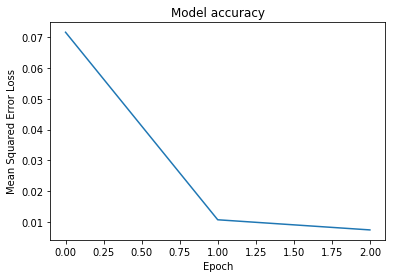

In [30]:
# Plot training & validation accuracy values
hist = model1._history()
plt.plot(hist.history['mean_squared_error'])
plt.title('Model accuracy')
plt.ylabel('Mean Squared Error Loss')
plt.xlabel('Epoch')
plt.show()
